# Deep Learning: Image Captioning using CNN , RNN & LSTM

In [1]:
#!pip install multiprocess
#!pip install torchsummary
#!pip install nltk
#!pip install torchtext
#!pip install spacy

Importing Modules

In [2]:
import sys
sys.path.append('..')
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import random
import seaborn as sns
import pandas as pd
import pickle
import nltk

#import program.model
#import program.data

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchtext.data.metrics import bleu_score
from torch.utils.tensorboard import SummaryWriter

In [3]:
sns.set_palette('Paired')
sns.set_style('whitegrid')

# Data

In [7]:
image_captions = pd.read_table('/kaggle/input/flickr8k/captions.txt', sep=',')
image_captions.head(2)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .


## Generate Train-Validate-Test

In [8]:
def generate_image_splits(image_folder, test_size=1000):
    images = np.array(os.listdir('./data/Images/'))
    np.random.shuffle(images)
    train_size = images.shape[0] - test_size
    train_images = images[:train_size]
    assert len(train_images) == train_size
    images = images[train_size:]

    test_images = images
    assert len(test_images) == test_size
    
    return (train_images, test_images)

In [9]:
generate_splits = False

if generate_splits:
    train_images, test_images = generate_image_splits(image_folder='./data/train/', 
                                                                     test_size=1000, validation_size=1000)

    # prepare files to copy with multiprocessing
    train_images = ['./data/Images/'+img for img in train_images]
    train_images = [img + '__' + './data/train/' + img.split('/')[-1] for img in train_images]

    test_images = ['./data/Images/'+img for img in test_images]
    test_images = [img + '__' + './data/test/' + img.split('/')[-1] for img in test_images]

In [10]:
# Check if works
function_check = False
if function_check:
    amount_test_images = 100
    test_img = train_images[:amount_test_images]
    program.data.copy_all_files(fp_from_to=test_img)

    for img in tqdm(test_img, desc='Deleting Images again'):
        assert os.path.isfile(img.split('__')[-1])
        os.remove(img.split('__')[-1])

In [11]:
copy_files = False
if copy_files:
    program.data.copy_all_files(fp_from_to=train_images)
    program.data.copy_all_files(fp_from_to=validation_images)
    program.data.copy_all_files(fp_from_to=test_images)

In [12]:
save_caps_per_split = False

if save_caps_per_split:
    train_caps = image_captions[image_captions['image'].isin(os.listdir('./data/train/'))]
    assert 5*len(os.listdir('./data/train/')) == train_caps.shape[0]
    train_caps.to_csv('./data/train_captions.csv', index=False)

    test_caps = image_captions[image_captions['image'].isin(os.listdir('./data/test/'))]
    assert 5*len(os.listdir('./data/test/')) == test_caps.shape[0]
    test_caps.to_csv('./data/test_captions.csv', index=False)

## Preprocess Text-Data

In [13]:
from multiprocess import Pool
import re
from collections import Counter

In [14]:
class TextPreprocessor(object):
    """Class handles text data."""
    
    def __init__(self, n_processes, max_sequence_length=None,
                 start_token='<START>', end_token='<END>', fill_token='<PAD>', unknown_token='<UNK>', 
                 pad_fill=True, disable_pbar=True):
        """
        Handles text from csvs, extract tokens with padding or without. Can create a dictionary with words
        to idx.        
        """
        self.n_processes = n_processes
        self.max_sequence_length = max_sequence_length
        self.start_token = start_token
        self.end_token = end_token
        self.fill_token = fill_token
        self.pad_fill = pad_fill
        self.unknown_token = unknown_token
        self.disable_pbar = disable_pbar
        self.longest_word = None
        self.tokenized_text = None
        self.text_dict = None
        self.text_dict_r = None
    
    @staticmethod
    def _longest_word(X):
        """Extracts longest word from all given sentences"""
        X_ = pd.Series(X)
        sentence_lengths = X_.map(lambda x: len(x.split(' ')))
        longest_word = max(sentence_lengths)
        
        return (sentence_lengths, longest_word)

    def tokenize(self, X, return_tokenized=False):
        """Tokenizes Sentence by the help of multiprocessing"""
        self.sentence_lengths, self.longest_word = self._longest_word(X=X)
        if self.max_sequence_length:
            # Overwrite props
            self.longest_word = self.max_sequence_length
        
        def __tokenize_words(s):
            s = re.sub(pattern=r'[^\w\s]', repl='', string=s)
            s = s.lower()
            #s = s.strip()
            w = s.split(' ')  
            if len(w) > self.longest_word:
                w = w[:self.longest_word]
            w.insert(0, self.start_token)
            w.append(self.end_token)
            if self.pad_fill:
                while len(w)-2 < self.longest_word:
                    w.append('<PAD>')
            
            return w
        
        with Pool(processes=self.n_processes) as pool:
            tokenized_text = pool.map(__tokenize_words, X)
        
        self.tokenized_text = tokenized_text
        
        if return_tokenized:
            return tokenized_text
    
    def create_txt_dict(self):
        """Creates a dictionary object which can be used to translate from word to idx"""
        self.text_dict = {self.start_token:1, self.end_token:2, self.unknown_token:3, self.fill_token:4}
        idx = 5

        for text in self.tokenized_text:
            for word in text:
                if not self.text_dict.get(word):
                    self.text_dict[word] = idx
                    idx += 1
        
        self.zero_index()
            
        return self
    
    def zero_index(self):
        val_range = np.arange(len(list(self.text_dict.values())))
        dict_keys = list(self.text_dict.keys())
        self.text_dict = dict(zip(dict_keys, val_range))
    
    def idx_to_word(self, idx: list):
        """Creates a reverse dictionary which can be used to translate from idx back to word"""
        if not self.text_dict:
            self.create_txt_dict()
        
        # Create dict to transform words back
        if not self.text_dict_r:
            self.text_dict_r = dict(zip(list(self.text_dict.values()), list(self.text_dict.keys())))
        
        return ' '.join([self.text_dict_r[id_] for id_ in idx.tolist()])
    
    def word_to_idx(self, word):
        """Takes a word and returns its index"""
        if not self.text_dict:
            self.create_txt_dict()
        
        return self.text_dict[word]
    
    def count_words(self):
        """Counts length of tokenized sentences."""
        concat_lists = []

        for L in tqdm(processor.tokenized_text, disable=self.disable_pbar):
            for element in L:
                concat_lists.append(element)
                
        return Counter(concat_lists)
    
class TextHandler(TextPreprocessor):
    
    def __init__(self, n_processes: int, max_sequence_length: int =None, unknown_threshold: float = None, start_token: str ='<START>', 
                 end_token: str ='<END>', fill_token: str='<PAD>', unknown_token: str ='<UNK>', pad_fill: bool =True, disable_pbar=True):
        """
        
        arguments:
        ------------------
        n_processes: int
            Amount processed to use for the tokenization
            
        unknown_threshold: int or float
            Less frequent words to remove from data
            
        start_token: str
            default: '<START>' Start token
        
        end_token: str
            default: '<END>', End token
        
        fill_token: str 
            default:'<PAD>', Pad token
        
        unknown_token: str
            default:'<UNK>', unknown token
        
        pad_fill: bool
            default=True, add_idx_for_new_word=False
        """
        super().__init__(n_processes=n_processes, max_sequence_length=max_sequence_length,
                         start_token=start_token, end_token=end_token, 
                         fill_token=fill_token, unknown_token=unknown_token, pad_fill=pad_fill, 
                         disable_pbar=disable_pbar)
        self.unknown_threshold = unknown_threshold
        self.disable_pbar = disable_pbar
        
        
    def fit(self, X: list):
        """"""
        self.tokenize(X, return_tokenized=False)
        self.create_txt_dict()
        if self.unknown_threshold:
            self._tokenize_unknown()
        
        return self
        
    def fit_transform(self, X: list):
        """"""
        self.fit(X)
        X = self.transform(X)
        
        return X
    
    def transform(self, X: list):
        """"""
        converted_tensors = []
        for s in tqdm(X, desc='Converting Sentences to Tensors', disable=self.disable_pbar):
            converted_sentence = self.convert_words_to_tensor(sentence=s)
            converted_tensors.append(converted_sentence)
            
        if len(converted_tensors)==1:
            converted_tensors = converted_tensors[0]
        
        return converted_tensors
    
    def inverse_transform(self, X: list):
        converted_sentences = []
        for t in tqdm(X, desc='Converting Tensors to Sentences', disable=self.disable_pbar):
            sentence = self.idx_to_word(t)
            converted_sentences.append(sentence)
        
        return converted_sentences
        
    def _tokenize_unknown(self):
        """Replaces less appearing words with unknown token"""
        word_counts = pd.Series(self.count_words())
        words = word_counts[word_counts > self.unknown_threshold].index.to_list()
        
        self.text_dict = {self.start_token:1, self.end_token:2, self.unknown_token:3, self.fill_token:4}
        token = 5
        for w in words:
            if w not in list(self.text_dict.keys()):
                self.text_dict[w] =  token
                token += 1
        self.text_dict_r = None
        
        self.zero_index()

        return self
        
    def convert_words_to_tensor(self, sentence: str):
        """Converts given sentence into a tensor."""
        if not self.text_dict:
            self.create_txt_dict()
            
        # Inner func for tokenization
        def __tokenize_words(s):
            s = re.sub(pattern=r'[^\w\s]', repl='', string=s)
            s = s.lower()
            #s = s.strip()
            w = s.split(' ')  
            if len(w) > self.longest_word:
                w = w[:self.longest_word]
            w.insert(0, self.start_token)
            w.append(self.end_token)
            if self.pad_fill:
                while len(w)-2 < self.longest_word:
                    w.append('<PAD>')
            
            return w
        
        tensor_convert = []
        for w in __tokenize_words(sentence):
            try:
                tensor_convert.append(self.text_dict[w])
            except:
                # if word is not in dict
                tensor_convert.append(self.text_dict[self.unknown_token])
                
        return torch.LongTensor(tensor_convert)

In [15]:
processor = TextPreprocessor(n_processes=8, max_sequence_length=10, start_token='<START>', end_token='<END>', pad_fill=True)

In [16]:
processor.tokenize(X = image_captions['caption'].to_list())

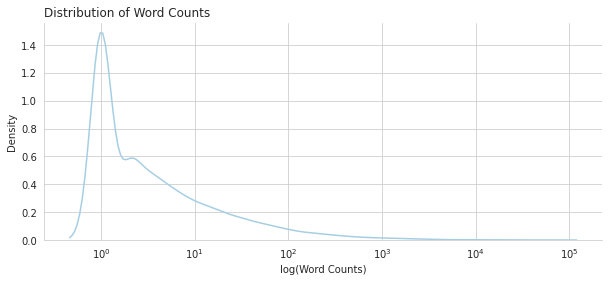

In [17]:
word_counts = processor.count_words()
word_counts = pd.Series(word_counts).sort_values(ascending=False)
word_counts = word_counts.drop([processor.end_token, processor.start_token, processor.fill_token])
#word_counts = np.log(word_counts)

fig = plt.subplots(figsize=(10, 4))
p = sns.kdeplot(word_counts, log_scale=True)
p.set_title('Distribution of Word Counts', loc='left')
p.set_xlabel('log(Word Counts)')
sns.despine()

plt.show()

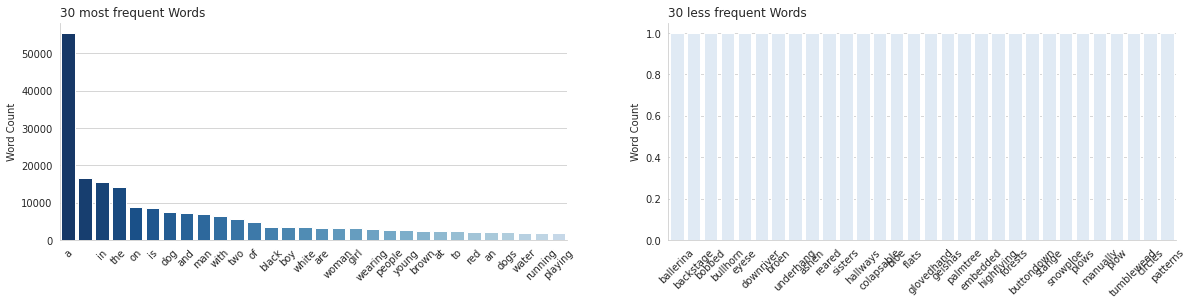

In [18]:
n = 30
word_counts = processor.count_words()
word_counts = pd.Series(word_counts).sort_values(ascending=False)
word_counts = word_counts.drop([processor.end_token, processor.start_token, processor.fill_token])
frequent_words = word_counts.head(n)

fig = plt.subplots(figsize=(20, 4))
plt.subplot(1,2,1)
p = sns.barplot(x=frequent_words.index, y=frequent_words, palette=sns.color_palette('Blues_r', n+10)[:n])
p.set_title(f'{n} most frequent Words', loc='left')
p.set_ylabel('Word Count')
plt.xticks(rotation=45)
sns.despine()

plt.subplot(1,2,2)
not_frequent_words = word_counts.tail(n)
p = sns.barplot(x=not_frequent_words.index, y=not_frequent_words, color=sns.color_palette('Blues_r', n)[-4])
p.set_title(f'{n} less frequent Words', loc='left')
p.set_ylabel('Word Count')
plt.xticks(rotation=45)
sns.despine()

plt.show()

**Description:**

Here, too, the right-handed form of the upper distribution can already be seen. You can see that filler words and prepositions appear first, which was to be expected. Words that appear afterwards are very interesting, such as: man, two, black, woman, girl etc. This already gives a small indication of what can mostly be seen in the pictures. I don't think it makes much sense to remove the frequently occurring words, since these words are used to form decent sentences.

In the plot on the right you can see the rarest words, which of course always differ in the plot, since most of them only appear once. The words are were rarely used to describe the images. It can therefore be concluded that these images only appear once in the dataset. It could definitely make sense to delete the few words that occur, since the data base is probably too small to teach a model here. I will thus remove words that appear only once.

In [19]:
word_counts[word_counts == 1].shape

(3292,)

We see that we have a lot of words that appear only once in the data, so I want to tag these words with the UNK tag, because the data set is too small for them to be properly trained. Another advantage here is the reduction in the amount of data.

In [20]:
processor = TextHandler(n_processes=7, max_sequence_length=None, pad_fill=False, unknown_threshold=1)

In [21]:
processor.fit(image_captions['caption'].tolist())

In [22]:
save_as_pickle = False

if save_as_pickle:
    with open('./data/wtoi_reduced.pkl', 'wb') as pkl_file:
        pickle.dump(processor.text_dict, pkl_file)

In [23]:
#with open('./data/wtoi_reduced.pkl', 'rb') as pkl_file:
#    processor.text_dict = pickle.load(pkl_file)

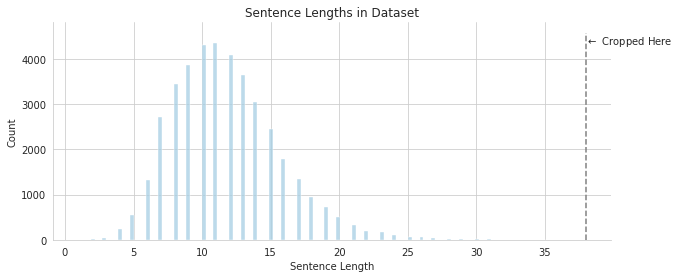

In [24]:
fig = plt.subplots(figsize=(10, 4))
p = sns.histplot(processor.sentence_lengths)
plt.vlines(x=processor.longest_word, ymin=p.axis()[-2], ymax=p.axis()[-1], 
           color='grey', linestyles='--')
plt.text(x=processor.longest_word, y=p.axis()[-1]*.90, s=r'$\leftarrow$ Cropped Here')
p.set_title('Sentence Lengths in Dataset')
p.set_xlabel('Sentence Length')
sns.despine()
plt.show()

You can see that most of the lengths are more normally distributed with mean around 10. It has some record lengths that are very long and can be called outliers.
I think it makes sense to reduce or even remove these sentences in our data set. For the time being, however, I will keep this size.

In [25]:
assert all([len(l) for l in processor.tokenized_text]) == True

In [26]:
image_captions['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [27]:
transformed_sentences = processor.transform(image_captions['caption'].tolist())
transformed_sentences[:2]

[tensor([ 0,  4,  5,  6,  4,  7,  8,  9, 10, 11,  4, 12, 13, 14,  6, 15,  2, 16,
         17,  1]),
 tensor([ 0,  4, 18, 19, 20,  4, 21, 22, 17,  1])]

In [28]:
transformed_sentences[3].shape

torch.Size([12])

In [29]:
assert all([len(l) for l in transformed_sentences]) == True

In [30]:
len(transformed_sentences[0])

20

In [31]:
processor.inverse_transform(transformed_sentences)[:2]

['<START> a child in a pink dress is climbing up a set of stairs in an <UNK> way  <END>',
 '<START> a girl going into a wooden building  <END>']

In [32]:
example = processor.transform(['My name is Simon and i like deep learning .'])
example

tensor([   0,    2, 5007,    9,    2,   31, 2952, 1217,  694, 3649,   17,    1])

In [33]:
processor.inverse_transform([example])

['<START> <UNK> name is <UNK> and i like deep learning  <END>']

## Loading Data

In [34]:
torch.cuda.is_available()

True

In [35]:
import os
import pandas as pd
from torchvision.io import read_image
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [36]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import torch
import pandas as pd
import os

class CustomDataset(Dataset):
    
    def __init__(self, annotations_file, img_dir, annot_transform=None, image_transform=None):
        self.annotation_file = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.annot_transform = annot_transform
        self.image_transform = image_transform

    def __len__(self):
        return len(self.annotation_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
                
        img_path = os.path.join(self.img_dir, self.annotation_file.iloc[idx, 0])
        image = read_image(img_path)
        label = self.annotation_file.iloc[idx, 1]
        if self.image_transform:
            image = self.image_transform(image)
        if self.annot_transform:
            label = self.annot_transform([label])
            
        return image, label

In [37]:
"""image_transforms = Compose([ToPILImage(),
                            Resize((224, 224)), 
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])"""
image_transforms = Compose([ToPILImage(),
                            Resize((224, 224)), 
                            ToTensor()])

In [39]:
train_dataset = CustomDataset(annotations_file='/kaggle/input/flickr8k/captions.txt', img_dir='../input/flickr8k/Images/', 
                              annot_transform=processor.transform, image_transform=image_transforms)
test_dataset = CustomDataset(annotations_file='/kaggle/input/flickr8k/captions.txt', img_dir='../input/flickr8k/Images/', 
                              annot_transform=processor.transform, image_transform=image_transforms)

# Modeling

In [41]:
def collate_fn(data):
    """Function to preprocess Batches after loading it with the Dataloader"""
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    # Extract length per caption
    lengths = [len(caption) for caption in captions]
    # Init zero tensor with amx length for each target 
    targets = torch.zeros(len(captions), max(lengths)).long() + 3
    for i, caption in enumerate(captions):
        end = lengths[i]
        # Replace part with target values and fill remaining with zeros
        targets[i, :end] = caption[:end]  
        
    return images, targets, lengths

In [42]:
def train_network(encoder, decoder, criterion, optimizer,n_epochs, 
                  dataloader_train, lr_scheduler=None, epsilon=.001,
                  writer=None, save_checkpoint_at=None, debug_run=False):
    """
    Trains a neural Network with given inputs and parameters.
    
    params:
    --------------------
    encoder: torch.Network
        Image Encoder Network to extract image features from images.
        
    decoder: torch.Network
        Decoder Network for Generating Image Captions
        
    criterion: 
        Cost-Function used for the network optimizatio
        
    optimizer: torch.Optimizer
        Optmizer for the network
        
    n_epochs: int
        Defines how many times the whole dateset should be fed through the network
        
    dataloader_train: torch.Dataloader 
        Dataloader with the batched dataset
        
    dataloader_val: torch.Dataloader
        Dataloader with validation set to calculate validation loss
        if None: No validation Loop will be performed during training
        
    lr_scheduler: float
        Learning Rate Scheduler, to adapt LR during training
        Will be multiplied at n-steps with a given Gamma Hyperparam
    
    writer:
        Tensorboard writer from from torchsummary SummaryWriter Instance
        
    epsilon: float
        Stopping Criterion regarding to change in cost-function between two epochs.
        
    save_checkpoint_at: str
        If this parameter is not None it will save the model at epoch.

    debug_run:
        If true than only one batch will be put through network.
        
    returns:
    ---------------------
    encoder:
        Trained Torch Encoder Model

    decoder:
        Trained Torch Decoder Model
        
    losses: dict
        dictionary of losses of all batches and Epochs.
        
    """
    print(20*'=', 'Start Training', 20*'=')
    if save_checkpoint_at:
        try:
            os.mkdir(save_checkpoint_at)
        except FileExistsError as ae:
            print(ae)
    batch_losses, epoch_losses = [], []
    dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    encoder.to(dev), decoder.to(dev)
    criterion.to(dev)

    encoder.train(), decoder.train()
    overall_length = len(dataloader_train)
    try: # To interrupt training whenever necessary wihtout loosing progress
        with tqdm(total=n_epochs*overall_length, disable=debug_run) as pbar:
            for epoch in range(n_epochs):  # loop over the dataset multiple times
                running_loss = 0.0
                for i, data in enumerate(dataloader_train):
                    # get the inputs
                    images, captions, lengths = data
                    images, captions = images.to(dev), captions.to(dev)
                    # zero the parameter gradients
                    encoder.zero_grad(), decoder.zero_grad()
                    
                    # forward + backward + optimize
                    features = encoder(images)
                    out = decoder(features, captions, lengths)
                    #print('Predicted for first batch', out[:len(captions[0])].argmax(1))
                    #print('True for first batch', captions[0])
                    
                    loss = criterion(out, captions.reshape(-1)) # Targets can be labels as documented for CE-Loss
                    loss.backward()
                    optimizer.step()

                    # calc and print stats
                    batch_losses.append(loss.item())
                    if writer:
                        writer.add_scalar('Loss/batch', loss.item(), i)
                    running_loss += loss.item()                
                    pbar.set_description(f'Epoch: {epoch+1}/{n_epochs} // Running Loss: {np.round(running_loss, 3)} ')
                    pbar.update(1)
                    if debug_run:
                        print('- Training Iteration passed. -')
                        break
                    
                if debug_run:
                    # Breaks loop 
                    print('Finished Debug Run')
                    break
                
                if save_checkpoint_at and not debug_run:
                    torch.save(encoder.state_dict(), save_checkpoint_at + f'checkpoint_encoder_ep{epoch}.ckpt')
                    torch.save(decoder.state_dict(), save_checkpoint_at + f'checkpoint_decoder_ep{epoch}.ckpt')

                if lr_scheduler:
                    lr_scheduler.step()

                print(f'Epoch {epoch+1} // Train Loss: {round(running_loss, 2)}')
                epoch_losses.append(running_loss)
                if writer:
                    writer.add_scalar('Loss/epoch', running_loss, epoch)
                if epoch > 0:
                    diff = np.abs(epoch_losses[-2] - running_loss)
                    if diff < epsilon:
                        print('- Network Converged. Stopping Training. -')
                        break
                        
    except KeyboardInterrupt as ke:
        # Handles Keyboardinterrupt and returns trained network and results
        print(ke)
        
    print(20*'=', 'Finished Training', 20*'=')
                                                 
    return encoder, decoder, dict(batch=batch_losses, 
                                    epoch=epoch_losses)

In [43]:
class EncoderCNN(nn.Module):
    """
    Encoder CNN Network for the encoding of images and generation of hidden state inputs for 
    RNN Decoder Model
    """
    def __init__(self, embed_size, pretrained=True):
        """
        
        arguments:
        --------------
        embed_size: int
            Size of the Word Embedding. (Vector Dimensionality of a Single Word)
            
        pretrained: bool
            If true uses pretrained CNN Model. Freezes all Convolutional and Pooling Layers of
            CNN Network.
        
        """
        super(EncoderCNN, self).__init__()
        self.pretrained = pretrained
        self.embed_size = embed_size
        resnet = models.resnet50(pretrained=pretrained)
        modules = list(resnet.children())[:-1]      
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)
        
    def forward(self, images):
        if self.pretrained:
            # Freezing of the Gradients does not create Graph Structure for autograd
            with torch.no_grad():
                features = self.resnet(images)
        else:
            # Creates Graph Structure
            features = self.resnet(images)
        # Reshape feature maps as a single feature vector
        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        features = self.bn(features)
        
        return features
    

class DecoderRNN(nn.Module):
    """
    Decoder RNN Network for the encoding of image features and generation of Image Captioning    
    """
    def __init__(self, embed_size, hidden_size, vocab_size, 
                 verbose=False, **kwargs):
        """
        
        arguments:
        ---------------
        embed_size: int
            Dimensionality of the Word Embedding. This is used to init the Weigh Matrix for the inputs of the RNN
            
        hidden_size: int
            Dimensionality of the hidden Size. Dimensionality of the hidden states appended behind each other (unrolled)
            
        vocab_size: int
            Size of the vocabulary = Amount of Words given for training.
            
        num_layers; int
             Number of layers of the LSTM to stack on top of each other taking the hidden states as input from the previous layer.       
        """
        super(DecoderRNN, self).__init__()
        self.vocab_size = vocab_size 
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.verbose = verbose
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dev = kwargs.get('device') if  kwargs.get('device') else self.__create_device()
        
    
    def __create_device(self):
        return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        
    def forward(self, features, captions, lengths):
        """
        Forward Prop with Teacher-Forcer Method. 
        Forces the Target to be the next input and not predicted label of previous.
        """
        hidden = None
        max_sequence_length = max(lengths)
        outputs = torch.empty((features.shape[0], captions.shape[1], self.vocab_size)).to(self.dev)
     
        # iteration N-1
        hidden, cell = self.lstm(features, hidden)
        feature_out = self.linear(hidden)
        outputs[:,0,:] = feature_out        
        
        captions = self.embed(captions)
        
        for t in range(max_sequence_length-1): # Not including last word as it need to be predicted by the previous
            # Step t used to predict step t+1
            inputs = captions[:, t, :]
            
            hidden, cell = self.lstm(inputs, (hidden, cell))
            out = self.linear(hidden)
            
            # Append each prediction to step t+1
            outputs[:, t+1, :] = out
                        
        return outputs.reshape(-1, self.vocab_size)
    
    
    def predict(self, features, max_sentence_length, end_token_id=1):
        predictions = []
        hidden = None
        
        # Iter N-1
        hidden, cell = self.lstm(features.unsqueeze(0), hidden)
        
        # Create Start Token as Tensor for first input
        inputs = torch.LongTensor([0])

        for t in range(max_sentence_length):
            inputs = self.embed(inputs)
            hidden, cell = self.lstm(inputs, (hidden, cell))
            out = self.linear(hidden)
            out = out.argmax(dim=1)
            if out == end_token_id:
                break
            predictions.append(out.item())
            inputs = out

        return predictions

In [44]:
BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 20

EMBED_SIZE = 512
HIDDEN_SIZE = 512

dataloader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, shuffle=True, pin_memory=True, 
                              collate_fn=collate_fn)
dataloader_test = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, shuffle=True, pin_memory=True, 
                             collate_fn=collate_fn)

In [45]:
encoder = EncoderCNN(embed_size=EMBED_SIZE, pretrained=True)
decoder = DecoderRNN(embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE,
                    vocab_size=max(processor.text_dict.values())+1, num_layers=1)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [46]:
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
#params = list(decoder.parameters()) + list(encoder.parameters()) 

In [47]:
optimizer = torch.optim.Adam(params, lr=.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=.9)

In [50]:
encoder, decoder, res = train_network(encoder=encoder, decoder=decoder, 
                                      criterion=criterion, optimizer=optimizer, 
                                      n_epochs=2, 
                                      dataloader_train=dataloader_train, 
                                      debug_run=False)

==================== Start Training ====================


  0%|          | 0/2530 [00:00<?, ?it/s]

Epoch 1 // Train Loss: 2163.46
Epoch 2 // Train Loss: 1790.09
==================== Finished Training ====================


In [51]:
save_model = True

if save_model:
    torch.save(obj=encoder, f='encoder{}eps_{}ed_{}hs_3_pretrained_notransforms'.format(EPOCHS, EMBED_SIZE, HIDDEN_SIZE))
    torch.save(obj=decoder, f='decoder{}eps_{}ed_{}hs_3_pretrained_notransforms'.format(EPOCHS, EMBED_SIZE, HIDDEN_SIZE))
    with open('results{}_eps.pkl'.format(EPOCHS), 'wb') as pkl_file:
        pickle.dump(res, pkl_file)

In [52]:
encoder.cpu() 
encoder.eval()
decoder.cpu()
decoder.eval()

DecoderRNN(
  (embed): Embedding(5225, 512)
  (lstm): LSTMCell(512, 512)
  (linear): Linear(in_features=512, out_features=5225, bias=True)
)

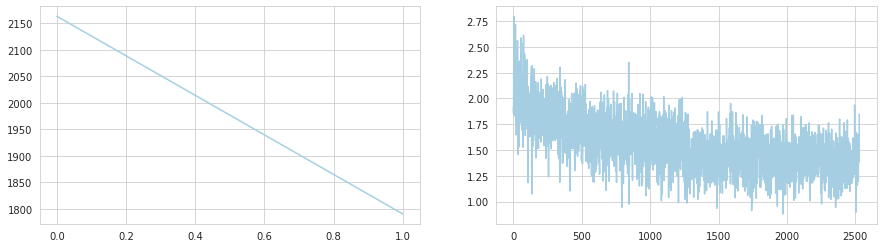

In [53]:
fig = plt.subplots(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(res['epoch'])

plt.subplot(1,2,2)
plt.plot(res['batch'])

plt.show()

## Sampling Images

In [54]:
def generate_captions(encoder, decoder, test_batch, limit=None, 
                      end_token_id: int = 1, start_token_id: int = 0, pad_token_id: int = 3,
                      **kwargs):    
    position_tokens = [start_token_id, end_token_id, pad_token_id]
    images, captions, _ = test_batch
    
    assert images.shape[0] >= limit
    
    ncols = 2
    nrows = (images.shape[0] // ncols ) + 1
    fig = plt.subplots(figsize=(20, nrows*4))
    
    with torch.no_grad():
        for i in range(images.shape[0] if not limit else limit):
            features = encoder(images[i].unsqueeze(0))
            predictions = decoder.predict(features.squeeze(), 30, 1)
            inverse_transform = Compose([ToPILImage()])
            
            predictions = [tok for tok in predictions if tok not in position_tokens]
            predictions = processor.idx_to_word(np.array(predictions))
            
            actual = [tok for tok in captions[i] if tok not in position_tokens]
            actual = processor.idx_to_word(np.array(actual))            
            
            plt.subplot(nrows, ncols, i+1)
            plt.imshow(inverse_transform(images[i]))
            plt.grid(False)
            plt.axis('off')
            
            plt.title('Predicted: ' + predictions + 
                      '\nActual: ' + actual, fontdict=dict(fontsize=10))
            
        plt.subplots_adjust(hspace=.5)

        plt.show()

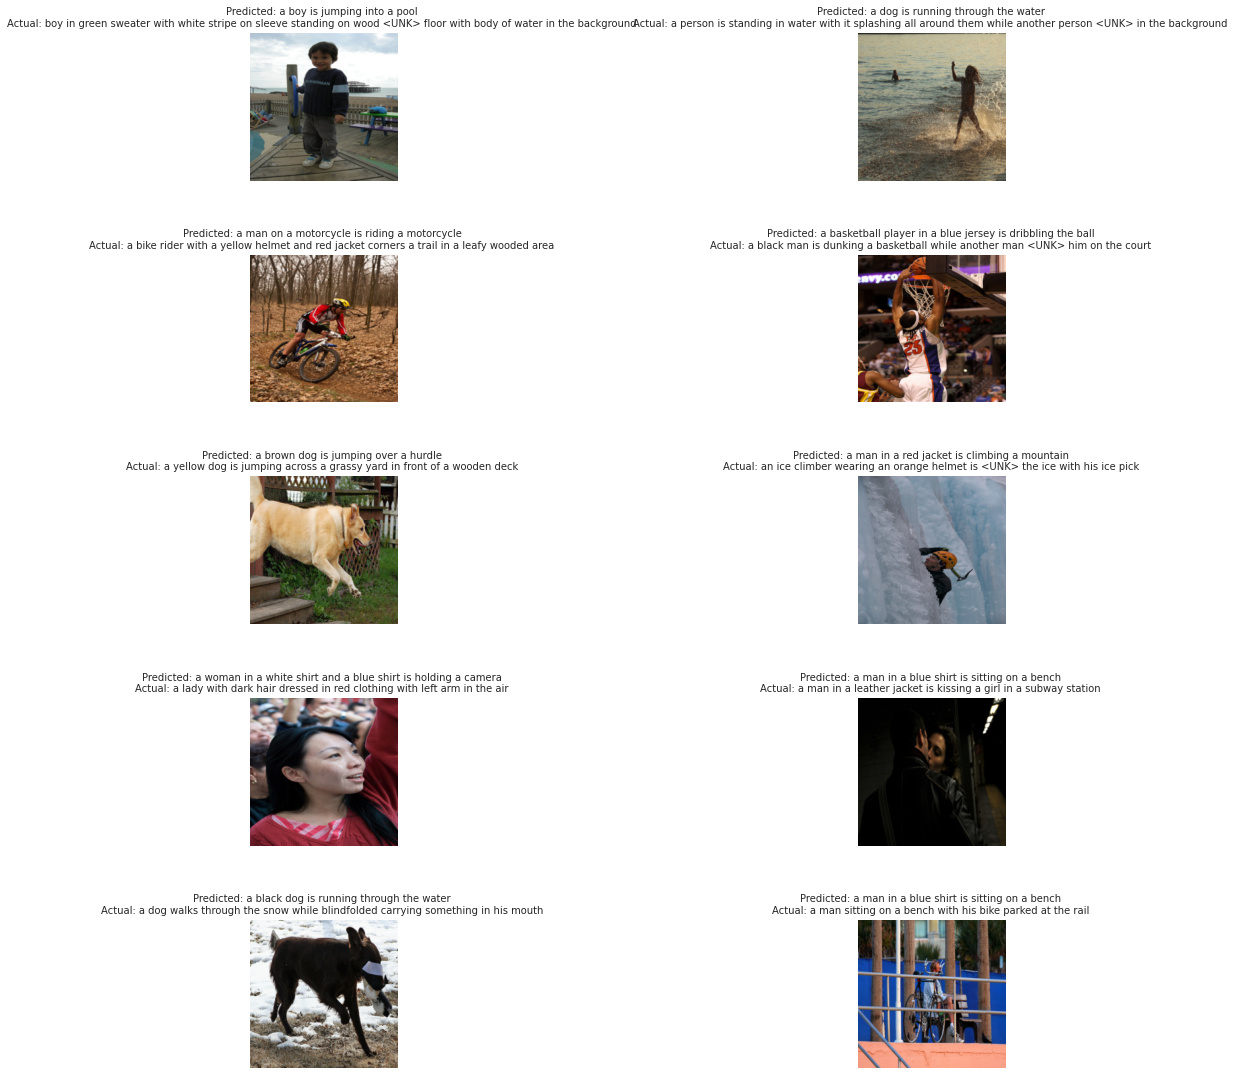

In [55]:
test_batch = next(iter(dataloader_test))
generate_captions(encoder=encoder, decoder=decoder, test_batch=test_batch, max_sequence_length=30, 
                  limit=10, end_token_id=processor.word_to_idx('<END>'), start_token_id=processor.word_to_idx('<START>'), 
                  pad_token_id=processor.word_to_idx('<PAD>'))

In [56]:
def evaluate_bleu(encoder, decoder, test_size=20, 
                  test_images_dir='./data/test/', test_captions_path = './data/test_captions.csv', 
                  position_tokens=[0, 1, 3], **kwargs):
    """
    Takes Encoder and Decoder as input and returns Bleu-Score on images from given set of captions. 
    Will always take all captions in the testset as reference corpus and the predicted caption as reference corpus.
    
    params:
    ----------
    encoder
        Encoder Network
        
    decoder
        Decoder Network
    
    test_images_dir='./data/test/'
        Path to image dir with all relevant images.
        
    test_captions_path = './data/test_captions.csv'
        path to captions file with all test_captions nevers seen by the network.
    
    position_tokens=[0, 1, 3] :
        Postional Tokens used in tokenization of captions
    
    **kwargs:
        'random_state' for equal sampling
    
    returns:
    ------------
    bleu_scores: list
        list of all calculated bleu_scores
    
    """
    test_images = os.listdir(test_images_dir)
    test_captions = pd.read_csv(test_captions_path)
    np.random.seed(seed=kwargs.get('random_state'))
    position_tokens = [0, 1, 3]
    
    if test_size:
        sample_image_names = test_captions['image'].unique()
        np.random.shuffle(sample_image_names)
        sample_image_names = sample_image_names[:test_size]
    else:
        sample_image_names = test_captions['image'].unique()
    sample_captions = test_captions[test_captions['image'].isin(sample_image_names)]
    
    scores = []
    with torch.no_grad():
        for img_name in tqdm(sample_image_names, desc='Calculating BLEU-Scores'):
            
            img_path = os.path.join(test_images_dir, img_name)
            image = read_image(img_path)

            all_captions = sample_captions.loc[sample_captions['image'] == img_name, 'caption'].to_list()
            all_captions = processor.transform(all_captions)
            all_captions = [caption[1:-1] for caption in all_captions]
            all_captions = processor.inverse_transform(all_captions)
            all_captions = [caption.strip().split(' ') for caption in all_captions]
            max_sequence_length = max([len(cap) for cap in all_captions])

            image = image_transforms(image).unsqueeze(0)
            features = encoder(image)
            prediction = decoder.predict(features=features.squeeze(), max_sentence_length=max_sequence_length, end_token_id=1)
            prediction = [tok for tok in prediction if tok not in position_tokens]
            prediction = processor.idx_to_word(np.array(prediction))
            prediction = prediction.strip().split(' ')

            score = bleu_score(candidate_corpus=[prediction], references_corpus=[all_captions])
            scores.append(score)
    
    return scores

In [58]:
scores = evaluate_bleu(encoder=encoder, decoder=decoder, test_size=100, 
                       test_images_dir='../input/flickr8k/Images', 
                       test_captions_path = '/kaggle/input/flickr8k/captions.txt', 
                       position_tokens=[0, 1, 3])

Calculating BLEU-Scores:   0%|          | 0/100 [00:00<?, ?it/s]

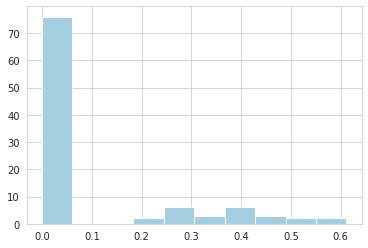

In [59]:
plt.hist(scores)
plt.show()

# Sources

https://arxiv.org/pdf/1411.4555.pdf

https://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorchhttps://www.kaggle.com/mdteach/image-captioning-with-out-attention-pytorch

https://medium.com/@stepanulyanin/captioning-images-with-pytorch-bc592e5fd1a3

https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

https://medium.com/@deepeshrishu09/automatic-image-captioning-with-pytorch-cf576c98d319

https://discuss.pytorch.org/t/image-captioning-example-doubt-in-input-size-of-decoder-lstm/14296

https://www.analyticsvidhya.com/blog/2018/04/solving-an-image-captioning-task-using-deep-learning/